## Imports and Definitions

In [49]:
from astropy.table import Table
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt

from scipy.interpolate import interp1d

import scipy as sp

In [11]:
hetvips_lamost = Table.read('hetvips_lamost.fits', format = 'fits')

In [12]:
# creating wavelength grid
wave_len = len(hetvips_lamost['spec'][0])
wave_arr = np.linspace(3470,5540,wave_len)
print(wave_len,len(wave_arr))

1036 1036


In [13]:
hetvips_lamost

objID_1,RA,Dec,shotid,gmag,rmag,imag,zmag,ymag,sn,barycor,mjd,exptime,chi2_star,chi2_galaxy,chi2_qso,z_star,z_galaxy,z_qso,z_best,classification,stellartype,ObjID_2,filename_1,index_in_file,spec,spec_error,spec_weight,RV_1,barycorr,SPECID_1,RA_1,DEC_1,SNR_U,SNR_G,SNR_R,SNR_I,SNR_Z,RV_2,RV_ERR,TEFF,TEFF_ERR,TEFF_FLAG,TEFF_GRADCORR,LOGG,LOGG_ERR,LOGG_FLAG,LOGG_GRADCORR,VMIC,VMIC_ERR,VMIC_FLAG,VMIC_GRADCORR,FEH,FEH_ERR,FEH_FLAG,FEH_GRADCORR,ALPHA_FE,ALPHA_FE_ERR,C_FE,C_FE_ERR,C_FE_FLAG,C_FE_GRADCORR,N_FE,N_FE_ERR,N_FE_FLAG,N_FE_GRADCORR,O_FE,O_FE_ERR,O_FE_FLAG,O_FE_GRADCORR,NA_FE,NA_FE_ERR,NA_FE_FLAG,NA_FE_GRADCORR,MG_FE,MG_FE_ERR,MG_FE_FLAG,MG_FE_GRADCORR,AL_FE,AL_FE_ERR,AL_FE_FLAG,AL_FE_GRADCORR,SI_FE,SI_FE_ERR,SI_FE_FLAG,SI_FE_GRADCORR,CA_FE,CA_FE_ERR,CA_FE_FLAG,CA_FE_GRADCORR,TI_FE,TI_FE_ERR,TI_FE_FLAG,TI_FE_GRADCORR,CR_FE,CR_FE_ERR,CR_FE_FLAG,CR_FE_GRADCORR,MN_FE,MN_FE_ERR,MN_FE_FLAG,MN_FE_GRADCORR,CO_FE,CO_FE_ERR,CO_FE_FLAG,CO_FE_GRADCORR,NI_FE,NI_FE_ERR,NI_FE_FLAG,NI_FE_GRADCORR,CU_FE,CU_FE_ERR,CU_FE_FLAG,CU_FE_GRADCORR,BA_FE,BA_FE_ERR,BA_FE_FLAG,BA_FE_GRADCORR,CHI2,CHI2RATIO,QFLAG_CHI2,CHI2_NA,CHI2RATIO_NA,QFLAG_CHI2NA,SNR_DPARALLAX,FLAG_SINGLESTAR,UQFLAG,STARID,SUBCLASS,FILENAME_2,specid_2,solution_id,designation,source_id,random_index,ref_epoch,ra_2,ra_error,dec_2,dec_error,parallax,parallax_error,parallax_over_error,pm,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_primary_flag,nu_eff_used_in_astrometry,pseudocolour,pseudocolour_error,ra_pseudocolour_corr,dec_pseudocolour_corr,parallax_pseudocolour_corr,pmra_pseudocolour_corr,pmdec_pseudocolour_corr,astrometric_matched_transits,visibility_periods_used,astrometric_sigma5d_max,matched_transits,new_matched_transits,matched_transits_removed,ipd_gof_harmonic_amplitude,ipd_gof_harmonic_phase,ipd_frac_multi_peak,ipd_frac_odd_win,ruwe,scan_direction_strength_k1,scan_direction_strength_k2,scan_direction_strength_k3,scan_direction_strength_k4,scan_direction_mean_k1,scan_direction_mean_k2,scan_direction_mean_k3,scan_direction_mean_k4,duplicated_source,phot_g_n_obs,phot_g_mean_flux,phot_g_mean_flux_error,phot_g_mean_flux_over_error,phot_g_mean_mag,phot_bp_n_obs,phot_bp_mean_flux,phot_bp_mean_flux_error,phot_bp_mean_flux_over_error,phot_bp_mean_mag,phot_rp_n_obs,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_bp_n_contaminated_transits,phot_bp_n_blended_transits,phot_rp_n_contaminated_transits,phot_rp_n_blended_transits,phot_proc_mode,phot_bp_rp_excess_factor,bp_rp,bp_g,g_rp,dr2_radial_velocity,dr2_radial_velocity_error,dr2_rv_nb_transits,dr2_rv_template_teff,dr2_rv_template_logg,dr2_rv_template_fe_h,l,b,ecl_lon,ecl_lat,dist,Separation_2,Separation
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,yr,deg,mas,deg,mas,mas,mas,,mas / yr,mas / yr,mas / yr,mas / yr,mas / yr,,,,,,,,,,,,,,,,,mas,,,,1 / um,1 / um,1 / um,,,,,,,,mas,,,,,deg,,,,,,,,deg,deg,deg,deg,,,'electron'.s**-1,'electron'.s**-1,,mag,,'electron'.s**-1,'electron'.s**-1,,mag,,'electron'.s**-1,'electron'.s**-1,,mag,,,,,,,mag,mag,mag,km / s,km / s,,K,log(cm.s**-2),'dex',deg,deg,deg,deg,,arcsec,arcsec
bytes16,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes7,bytes1,bytes16,bytes58,int64,float64[1036],float64[1036],float64[1036],float64,float64,bytes36,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,float32,float32,float32,int16,float32,float32,float32,int16,float32,float32,float32,int16,

## Interpolating

In [14]:
example = hetvips_lamost['spec'][0]

# filling masked indices with nans
nan_spec = example.filled(np.nan)

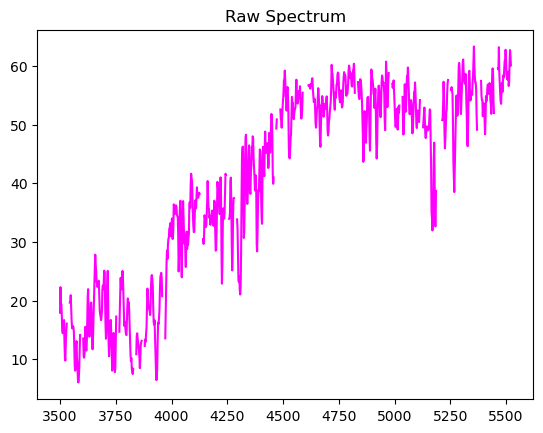

In [15]:
plt.title('Raw Spectrum')
plt.plot(wave_arr,nan_spec,color='magenta')

In [16]:
# filling the nans
nan_indices = np.isnan(nan_spec)
x_len = np.arange(len(nan_spec))

# defining what will be interpolated
x = x_len[nan_indices]
xp = x_len[~nan_indices]
fp = nan_spec[~nan_indices]

interp_values = np.interp(x, xp, fp)
resampled_spec = nan_spec
resampled_spec[nan_indices] = interp_values

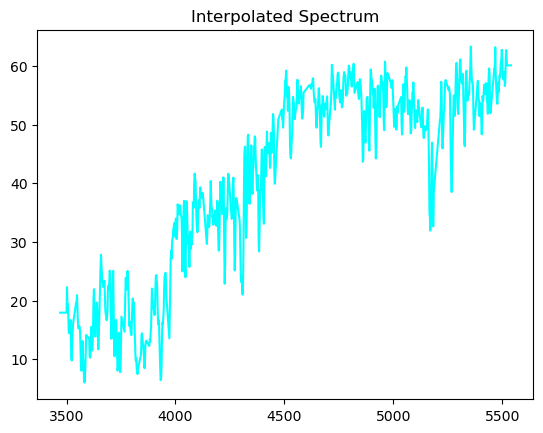

In [17]:
plt.title('Interpolated Spectrum')
plt.plot(wave_arr,resampled_spec,color='cyan')

In [88]:
# creating general definition
def interpolation(spectrum):
    # defining masked indices as nans
    nan_spec = example.filled(np.nan)
    
    # filling the nans
    nan_indices = np.isnan(nan_spec)

    # defining what will be interpolated
    x_len = np.arange(len(nan_spec))
    x = x_len[nan_indices]
    xp = x_len[~nan_indices]
    fp = nan_spec[~nan_indices]

    # interpolating
    interp_values = np.interp(x, xp, fp)
    resampled_spec = nan_spec
    resampled_spec[nan_indices] = interp_values

    return [resampled_spec]

## Continuum Normalizing

In [27]:
slice = 100
cont_arr = []

for i in range(len(resampled_spec)):
    sliced_spec = resampled_spec[i:slice]
    cont = np.percentile(sliced_spec, 95)
    cont_arr.append(cont)
    slice = slice + 1

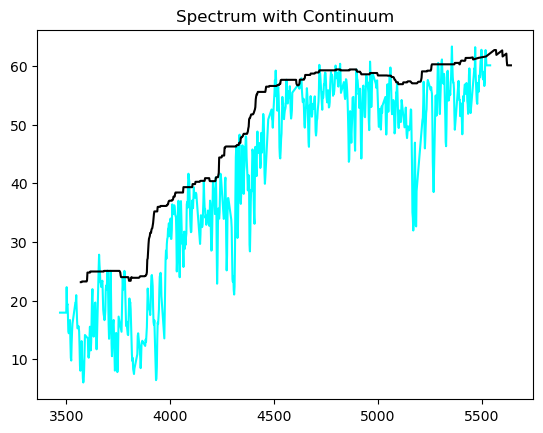

In [28]:
plt.title('Spectrum with Continuum')
plt.plot(wave_arr,resampled_spec,color='cyan')
plt.plot(wave_arr+100,cont_arr,color='black')

In [30]:
# continuum normalizing
sub_spec = resampled_spec[100:1036]
sub_cont = cont_arr[0:936]
sub_wave = wave_arr[100:1036]

In [31]:
normalized_spec = sub_spec / sub_cont

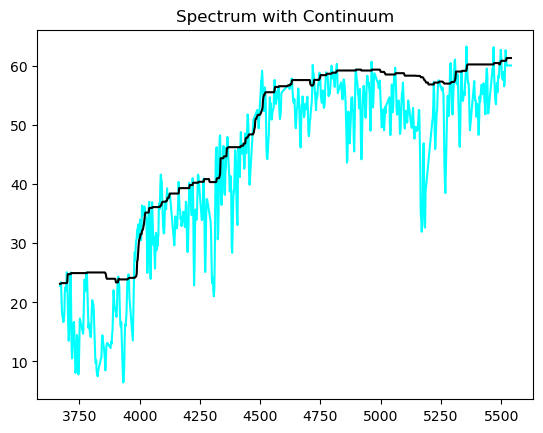

In [32]:
plt.title('Spectrum with Continuum')
plt.plot(sub_wave,sub_spec,color='cyan')
plt.plot(sub_wave,sub_cont,color='black')

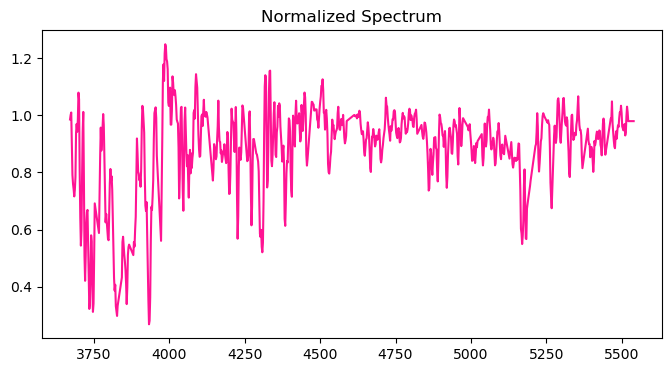

In [60]:
plt.figure(figsize=(8,4))
plt.title('Normalized Spectrum')
plt.plot(sub_wave,normalized_spec,color='deeppink')

In [92]:
# creating general definition
def normalization(spectrum,percent):
    slice = 100
    cont_arr = []

    for i in range(len(spectrum)):
        sliced_spec = spectrum[i:slice]
        cont = np.percentile(sliced_spec, percent)
        cont_arr.append(cont)
        slice = slice + 1
    
    sub_spec = spectrum[100:1036]
    sub_cont = cont_arr[0:936]

    normalized_spec = sub_spec / sub_cont
    
    return sub_cont, sub_spec , [normalized_spec]

## Applying Interpolations and Normalizations to all Science Spectra

In [94]:
# hetvips_lamost['smooth_spec'] = interpolation(hetvips_lamost['spec'])
# hetvips_lamost['chop_norm_spec'] = normalization(hetvips_lamost['smooth_spec'],95)[2]

## Matching Template Spectra

In [33]:
template = Table.read('../RVgrid/T4000_g0.50_f-0.50.spec.conv',format='ascii')

In [34]:
template

col1,col2,col3
float64,float64,float64
3470.0,0.18403,28037.0
3470.1,0.189103,28811.6
3470.2,0.193924,29548.1
3470.3,0.198473,30243.3
3470.4,0.202729,30894.0
3470.5,0.206673,31497.4
3470.6,0.210289,32051.0
3470.7,0.213564,32552.6
3470.8,0.216484,33000.4


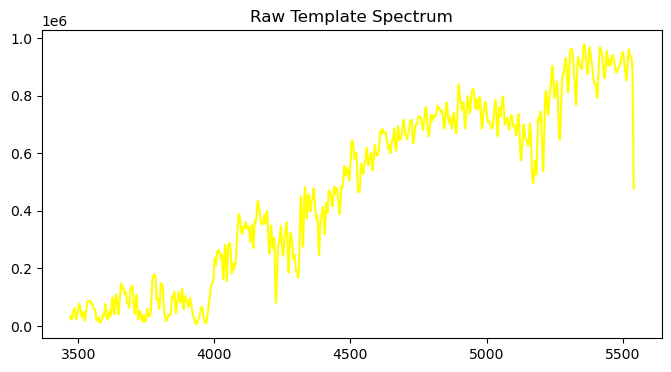

In [50]:
plt.figure(figsize=(8,4))
plt.title('Raw Template Spectrum')
plt.plot(template['col1'],template['col3'],color='yellow')

In [81]:
# defining what will be interpolated
x = wave_arr
xp = np.arange(len(template))
fp = template['col3']

# interp_temp = np.interp(x, xp, fp)
interp_temp = np.interp(x,template['col1'],template['col3'])
cont_temp, sub_temp, norm_temp = normalization(interp_temp,95)

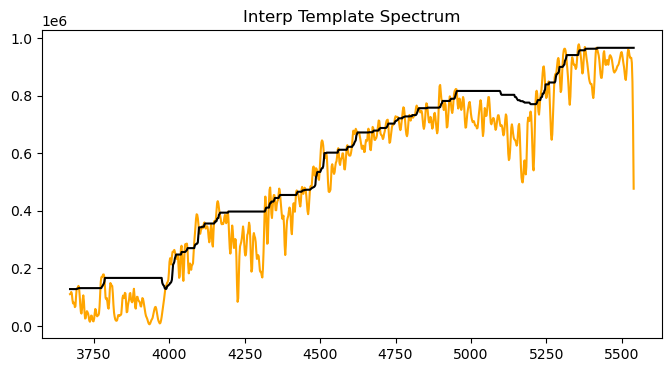

In [82]:
plt.figure(figsize=(8,4))
plt.title('Interp Template Spectrum')
plt.plot(sub_wave,sub_temp,color='orange')
plt.plot(sub_wave,cont_temp,color='black')

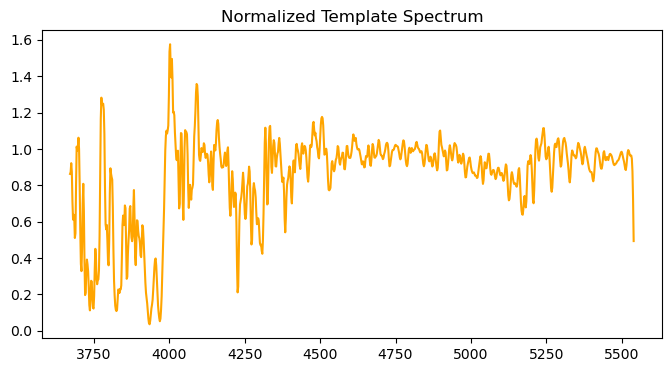

In [83]:
plt.figure(figsize=(8,4))
plt.title('Normalized Template Spectrum')
plt.plot(sub_wave,norm_temp,color='orange')

In [ ]:
# doing for all template spectra


## Computing Chi2
#### Chi2 equation is $\Sigma(F_{obs} - F_{temp})^2$ / $\sigma_{obs err}^2$